# Part d) Testing different activation functions and depths of the neural network

You should also test different activation functions for the hidden layers. Try out the Sigmoid, the RELU and the Leaky RELU functions and discuss your results. Test your results as functions of the number of hidden layers and nodes. Do you see signs of overfitting? It is optional in this project to perform a bias-variance trade-off analysis.

In [1]:
import sys, os

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns

import matplotlib.style as mplstyle

mplstyle.use(["ggplot", "fast"])

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 12,
})

funcs = '/Users/kjesta/Desktop/Masteremner/FYS-STK4155/Project_2_FYSSTK/Code'
sys.path.append(os.path.abspath(funcs))

from functions import *

%load_ext autoreload
%autoreload 2

np.random.seed(42)

Making the dataset, consiting of 1000 data points for 1-D Runge function with added stochastic noise. The noise has mean zero and standard deviation 0.1. the we split the data into training and testing sets, where the test set is 20% of the full data. We normalize the data.

In [2]:
n = 1000
x = np.linspace(-1, 1, n)
x = x.reshape(-1, 1)

y = runge_function(x) + np.random.normal(0, 0.1, (n,1))

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)
X_train_norm = (X_train - X_mean) / X_std
X_test_norm  = (X_test - X_mean) / X_std

To assess how network depth and width influence network performance, we train the network with different number of hidden layers and different number of nodes per layer. In addition to that, we see how different activation functions in the hidden layers impact the performance.

In [3]:
layer_options = [1, 2, 3, 4, 5]
node_options = [2, 4, 8, 16, 32, 64]
hidden_layers_options = [[n]*l for l in layer_options for n in node_options]  # different numbers of hidden layers and nodes
activation_options = [sigmoid, RELU, LRELU]  # different activation functions for hidden layers

The neural network is trained with the above parameters and the results are stored in a Pandas dataframe. The metric used to assess performance is mean squared error.

In [4]:
results = []

for layers in hidden_layers_options:
    for activate in activation_options:
        #print(f"Training NN with layers {layers} and activation {activate.__name__}...")

        activation_funcs = [activate]*len(layers) + [identity]  # hidden + output
        activation_ders  = [derivate(activate) for _ in layers] + [derivate(identity)]

        # Initialize network
        nn = NeuralNetwork(
            network_input_size=X_train.shape[1],
            layer_output_sizes=layers + [1],
            activation_funcs=activation_funcs,
            activation_ders=activation_ders,
            cost_fun=mse,
            cost_der=mse_der
        )
        
        # Train network with stochastic gradient descent
        nn.train_SGD(X_train, y_train, epochs=500, learning_rate=0.001)

        y_pred_test = nn._feed_forward(X_test)
        y_pred_train = nn._feed_forward(X_train)
        
        # Compute errors
        train_err = mse(y_pred_train, y_train)
        test_err  = mse(y_pred_test, y_test)
        
        results.append({
            "layers": layers,
            "activation": activate.__name__,
            "y_pred_test": y_pred_test,
            "y_pred_train": y_pred_train,
            "train_error": train_err,
            "test_error": test_err
        })

df = pd.DataFrame(results)
df

,layers,activation,y_pred_test,y_pred_train,train_error,test_error
0,[2],sigmoid,"[[0.32239828124695186], [0.23119254840092524],...","[[0.5065034156463705], [0.3164209356191008], [...",0.105089,0.097865
1,[2],RELU,"[[0.291512440044165], [0.3154052921945816], [0...","[[0.23708983236821612], [0.29306105083169204],...",0.090123,0.083609
2,[2],LRELU,"[[0.45668588580543246], [0.45717859219703166],...","[[0.45556361013567864], [0.45671782047896203],...",0.120875,0.118246
3,[4],sigmoid,"[[0.27005179823019065], [0.18759552006059854],...","[[0.48225130748591616], [0.2644766416215777], ...",0.106088,0.097509
4,[4],RELU,"[[0.5888618124669134], [0.3770200273394795], [...","[[0.9446052148664009], [0.5787390327238385], [...",0.230411,0.222965
...,...,...,...,...,...,...
85,"[32, 32, 32, 32, 32]",RELU,"[[5.797041666308002], [3.7538693735160513], [3...","[[-2.83503665127377], [5.782134216791616], [3....",11.554655,12.044848
86,"[32, 32, 32, 32, 32]",LRELU,"[[-0.33562493111825975], [0.11539311912731276]...","[[-1.245898282873681], [-0.6570045933543784], ...",3.440206,3.593094
87,"[64, 64, 64, 64, 64]",sigmoid,"[[0.7065779668037868], [0.16784560890141398], ...","[[-0.05339180123613185], [0.6976002323940571],...",0.020322,0.021725
88,"[64, 64, 64, 64, 64]",RELU,"[[18.255263740602334], [11.514949686796959], [...","[[10.631797721577518], [23.526911198109577], [...",173.945083,167.884100


Plotting the MSE as a function of hidden layers.

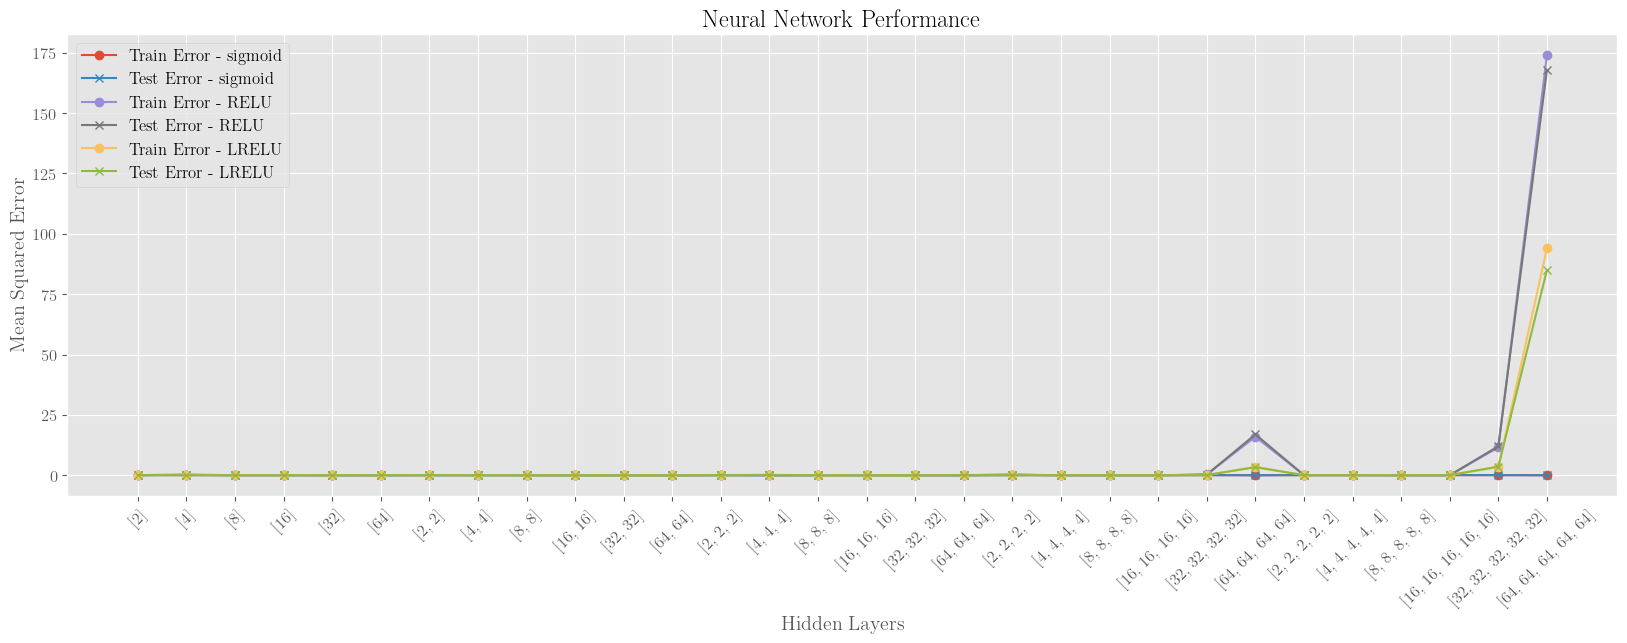

In [5]:
fig, ax = plt.subplots(figsize=(20,6))

for activate in df['activation'].unique():
    subset = df[df['activation'] == activate]
    ax.plot(subset['layers'].astype(str), subset['train_error'], marker='o', label=f'Train Error - {activate}')
    ax.plot(subset['layers'].astype(str), subset['test_error'], marker='x', label=f'Test Error - {activate}')

ax.set_xlabel("Hidden Layers")
ax.set_ylabel("Mean Squared Error")
ax.set_title("Neural Network Performance")
ax.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

RELU and LRELU explodes for deep networks, so to see what is going on we zoom in on the y axis below.

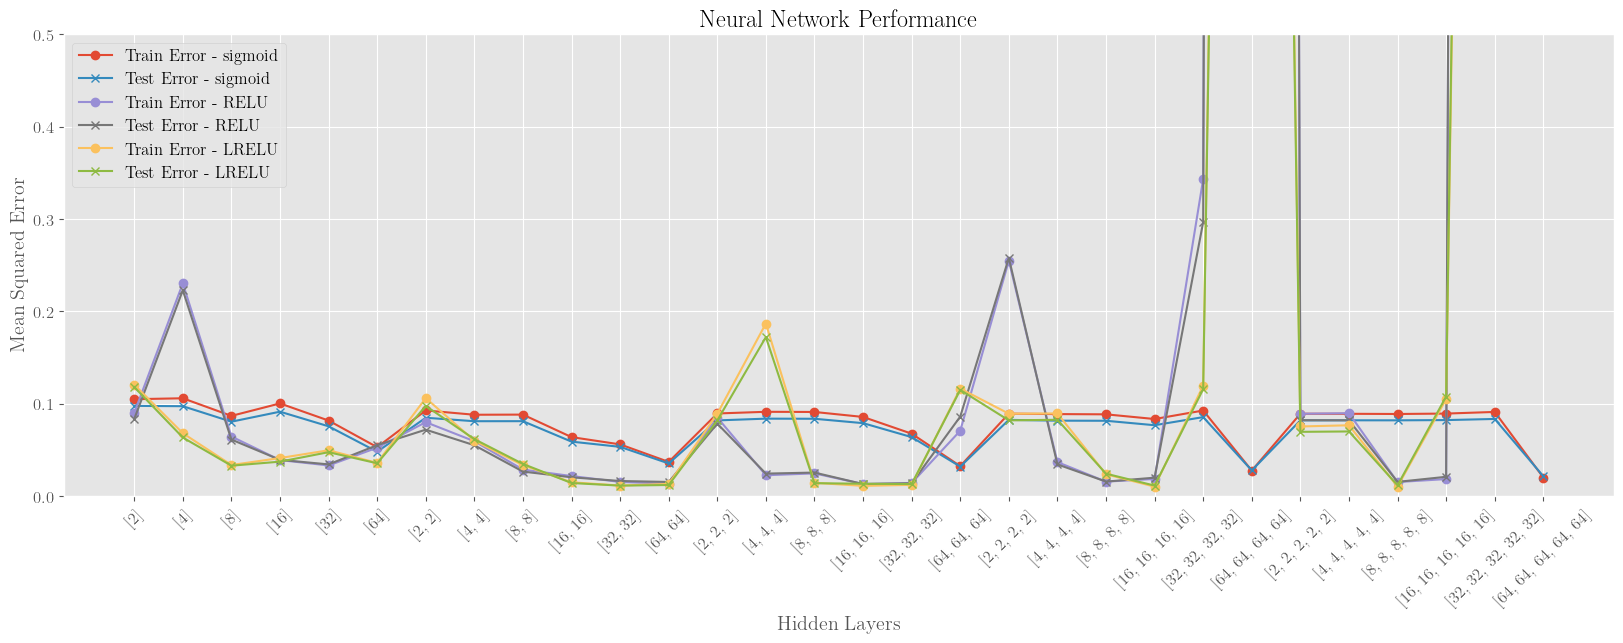

In [6]:
fig, ax = plt.subplots(figsize=(20,6))

for activate in df['activation'].unique():
    subset = df[df['activation'] == activate]
    ax.plot(subset['layers'].astype(str), subset['train_error'], marker='o', label=f'Train Error - {activate}')
    ax.plot(subset['layers'].astype(str), subset['test_error'], marker='x', label=f'Test Error - {activate}')

ax.set_ylim(0, 0.5)

ax.set_xlabel("Hidden Layers")
ax.set_ylabel("Mean Squared Error")
ax.set_title("Neural Network Performance")
ax.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Now we plot heatmaps to better see the impact on MSE of the number of nodes and number of hidden layers.

In [7]:
df["n_hidden_layers"] = df["layers"].apply(len)
df["n_nodes"] = df["layers"].apply(lambda x: x[0])

activations = df['activation'].unique()

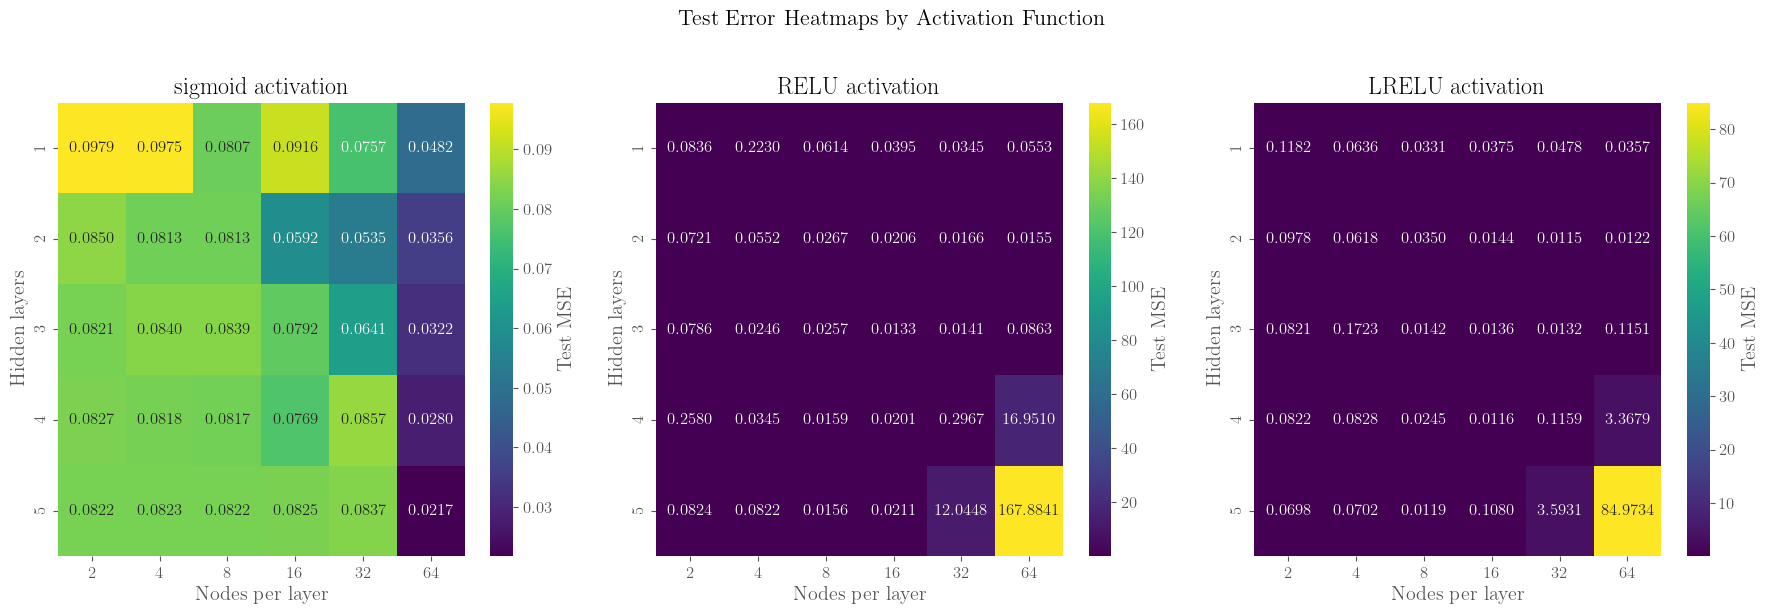

In [8]:
fig, axes = plt.subplots(1, len(activations), figsize=(18, 6))

for ax, act in zip(axes, activations):
    subset = df[df["activation"] == act]
    heatmap_data = subset.pivot_table(
        index="n_hidden_layers",
        columns="n_nodes",
        values="test_error",
        aggfunc="mean"
    )

    sns.heatmap(
        heatmap_data,
        annot=True,
        fmt=".4f",
        cmap="viridis",
        cbar_kws={'label': 'Test MSE'},
        ax=ax
    )

    ax.set_title(f"{act} activation")
    ax.set_xlabel("Nodes per layer")
    ax.set_ylabel("Hidden layers")

fig.suptitle("Test Error Heatmaps by Activation Function", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

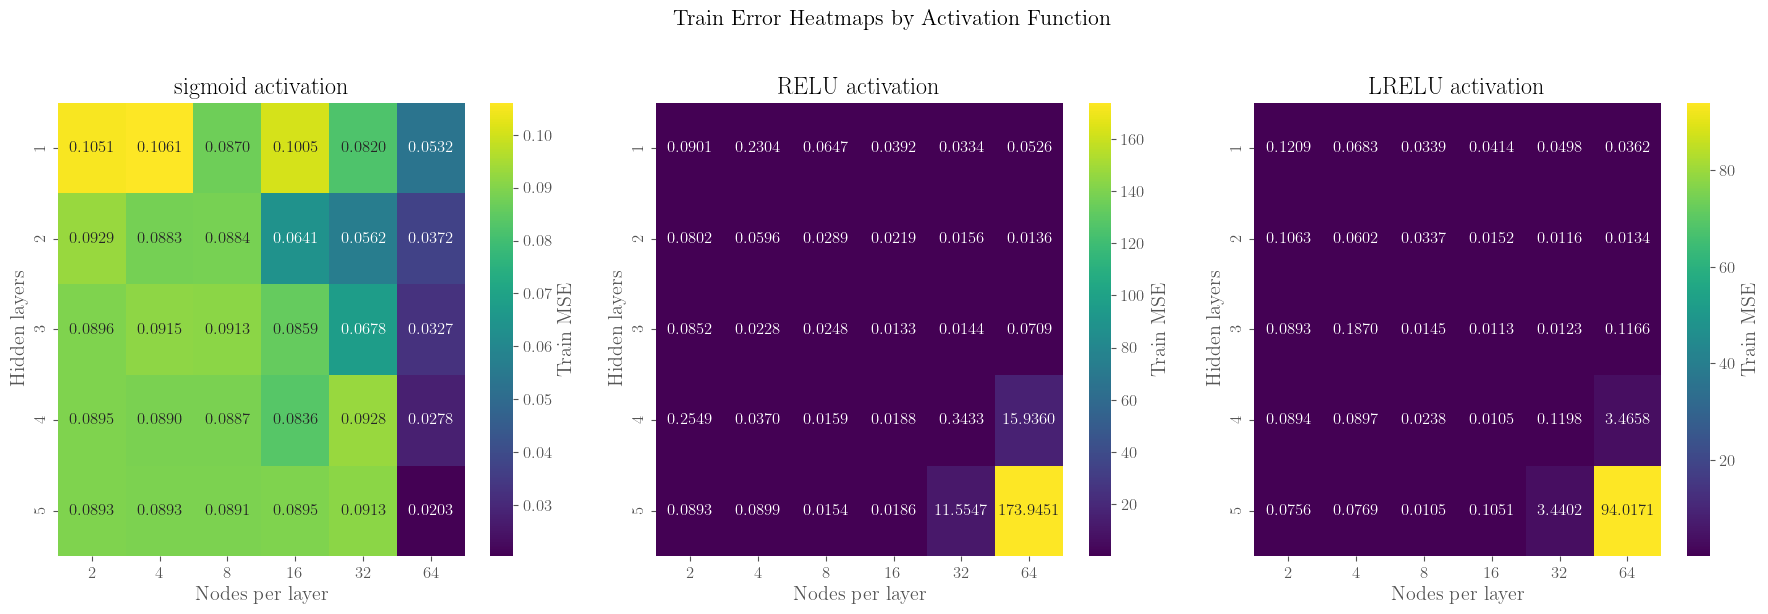

In [9]:
fig, axes = plt.subplots(1, len(activations), figsize=(18, 6))

for ax, act in zip(axes, activations):
    subset = df[df["activation"] == act]
    heatmap_data = subset.pivot_table(
        index="n_hidden_layers",
        columns="n_nodes",
        values="train_error",
        aggfunc="mean"
    )

    sns.heatmap(
        heatmap_data,
        annot=True,
        fmt=".4f",
        cmap="viridis",
        cbar_kws={'label': 'Train MSE'},
        ax=ax
    )

    ax.set_title(f"{act} activation")
    ax.set_xlabel("Nodes per layer")
    ax.set_ylabel("Hidden layers")

fig.suptitle("Train Error Heatmaps by Activation Function", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [28]:
best_sigmoid_test = df[df["activation"] == "sigmoid"].sort_values("test_error").iloc[0]
best_RELU_test = df[df["activation"] == "RELU"].sort_values("test_error").iloc[0]
best_LRELU_test = df[df["activation"] == "LRELU"].sort_values("test_error").iloc[0]

In [32]:
best_sigmoid_train = df[df["activation"] == "sigmoid"].sort_values("train_error").iloc[0]
best_RELU_train = df[df["activation"] == "RELU"].sort_values("train_error").iloc[0]
best_LRELU_train = df[df["activation"] == "LRELU"].sort_values("train_error").iloc[0]

In [35]:
print("Best Sigmoid Test:", best_sigmoid_test)
print()
print("Best Sigmoid Train:", best_sigmoid_train)
print()
print()
print("Best RELU Test:", best_RELU_test)
print()
print("Best RELU Train:", best_RELU_train)
print()
print()
print("Best LRELU Test:", best_LRELU_test)
print()
print("Best LRELU Train:", best_LRELU_train)

Best Sigmoid Test: layers                                          [64, 64, 64, 64, 64]
activation                                                   sigmoid
y_pred_test        [[0.7065779668037868], [0.16784560890141398], ...
y_pred_train       [[-0.05339180123613185], [0.6976002323940571],...
train_error                                                 0.020322
test_error                                                  0.021725
n_hidden_layers                                                    5
n_nodes                                                           64
Name: 87, dtype: object

Best Sigmoid Train: layers                                          [64, 64, 64, 64, 64]
activation                                                   sigmoid
y_pred_test        [[0.7065779668037868], [0.16784560890141398], ...
y_pred_train       [[-0.05339180123613185], [0.6976002323940571],...
train_error                                                 0.020322
test_error                             

* Sigmoid: tends to saturate (vanishing gradients), so performance often degreades with depth (number of hidden layers).
* ReLU: Usually performs best for deeper networks due to non-saturating gradient.
* Leaky ReLU: Often similar to ReLU but better for very deep networks (less dead neurons).

* Increasing nodes/layers usually improves training performance but may increase overfitting.

# Part e) Testing different norms

Still using the one-dimensional Runge function, add now the hyperparameters $\lambda$ with the $L_2$ and $L_1$ norms. Find the optimal results for the hyperparameters $\lambda$ and the learning rates $\eta$ and neural network architecture and compare the $L_2$ results with Ridge regression from project 1 and the $L_1$ results with the Lasso calculations of project 1. 

To avoid crashing my computer I have chosen to work with the best architectures from part d) and use these to assess hyperparameter and learning rates with added norms. 

In [44]:
best_architectures = {
    "sigmoid": [64, 64, 64, 64, 64],
    "RELU": [16, 16, 16],
    "LRELU": [32, 32]
}

activation_funcs = {
    "sigmoid": sigmoid,
    "RELU": RELU,
    "LRELU": LRELU
}

lambda_options = [0.0, 0.0001, 0.001, 0.01, 0.1]
learning_rate_options = [0.001, 0.01, 0.1]

In [45]:
results_reg = []

for act_name, layers in best_architectures.items():
    for reg_type in ["L1","L2"]:
        for lamb in lambda_options:
            for lr in learning_rate_options:
                activate = activation_funcs[act_name]
                
                activation_funcs_list = [activate]*len(layers) + [identity]
                activation_ders_list  = [derivate(activate) for _ in layers] + [derivate(identity)]
                
                nn = NeuralNetwork(
                    network_input_size=X_train.shape[1],
                    layer_output_sizes=layers + [1],
                    activation_funcs=activation_funcs_list,
                    activation_ders=activation_ders_list,
                    cost_fun=mse,
                    cost_der=mse_der,
                    lamb=lamb,
                    cost_fun_type=reg_type
                )
                
                nn.train_SGD(X_train_norm, y_train, epochs=200, learning_rate=lr, batch_size=20)
                
                y_pred_test = nn._feed_forward(X_test_norm)
                y_pred_train = nn._feed_forward(X_train_norm)
                
                results_reg.append({
                    "architecture": act_name,
                    "layers": layers,
                    "activation": act_name,
                    "reg_type": reg_type,
                    "lambda": lamb,
                    "learning_rate": lr,
                    "train_error": mse(y_pred_train, y_train),
                    "test_error": mse(y_pred_test, y_test)
                })

In [46]:
df_reg = pd.DataFrame(results_reg)

# Best network for each combination
best_L2 = df_reg[df_reg["reg_type"]=="L2"].sort_values("test_error").iloc[0]
best_L1 = df_reg[df_reg["reg_type"]=="L1"].sort_values("test_error").iloc[0]

print("Best L2 network:")
print(best_L2[["architecture","layers","lambda","learning_rate","train_error","test_error"]])

print("Best L1 network:")
print(best_L1[["architecture","layers","lambda","learning_rate","train_error","test_error"]])


Best L2 network:
architecture                  sigmoid
layers           [64, 64, 64, 64, 64]
lambda                            0.0
learning_rate                     0.1
train_error                  0.009944
test_error                    0.00989
Name: 17, dtype: object
Best L1 network:
architecture             RELU
layers           [16, 16, 16]
lambda                 0.0001
learning_rate             0.1
train_error          0.009851
test_error            0.01004
Name: 35, dtype: object


**From project 1**

Ridge/L2 regression:
- The optimal $\lambda$ was found to be smaller than $10^{-3}$.
- Learning rate: ??

Lasso/L1 regression:
- The optimal $\lambda$ was found to be ??
- Learning rate??

Here’s a concise summary of the **Ridge** and **Lasso regression results** from your report (*Project1_FYSSTK.pdf*), focusing on their **hyperparameters**, **learning rates**, **best polynomial degree**, and **MSE performance**:

---

## 🔹 **Ridge Regression**

### **Hyperparameter (λ)**

* Ridge regression includes an **L₂ regularization** term controlled by **λ**.
* They tested λ values from **10⁻¹⁰ up to 10¹**.
* **Optimal λ ≈ 1×10⁻⁴**, found using **10-fold cross-validation**.
* For **λ < 10⁻³**, Ridge’s MSE barely changed — performance was stable at small regularization levels.
* Larger λ increased bias and test MSE by shrinking coefficients too strongly.

### **Learning Rate (η)**

* Ridge was **less sensitive** to learning rate compared to OLS and Lasso.
* Converged well even for small η (0.001–0.01).
* Optimal performance found around **η ≈ 0.1** for gradient descent methods.
* With adaptive optimizers (Adam/RMSProp), **η = 0.1** gave the best convergence and lowest cost.

### **Best Polynomial Degree & MSE**

* **Best degree:** **12**
* **Best λ:** **1.0×10⁻⁴**
* **10-fold CV MSE:** **≈ 0.0109**
* Ridge performed similarly to OLS at low degrees and slightly worse at high degrees (due to coefficient shrinkage).

---

## 🔹 **Lasso Regression**

### **Hyperparameter (λ)**

* Lasso uses an **L₁ regularization** term that can zero out coefficients.
* They scanned λ across the same log range (10⁻⁴ to 10⁰).
* **Optimal λ ≈ 1×10⁻⁴**, also found from **10-fold CV**.
* For larger λ, MSE increased rapidly due to excessive shrinkage (over-penalization).

### **Learning Rate (η)**

* Sensitive to η; too large (≥0.2–0.3) caused unstable updates.
* Best convergence and test MSE observed around **η ≈ 0.1**.
* Like Ridge, adaptive methods (Adam, RMSProp) worked well, with **Adam + η = 0.1** giving the smoothest convergence.

### **Best Polynomial Degree & MSE**

* **Best degree:** **8**
* **Best λ:** **1.0×10⁻⁴**
* **10-fold CV MSE:** **≈ 0.0143**

Lasso favored simpler models — its L₁ penalty pruned higher-order coefficients, reducing variance but increasing bias slightly compared to Ridge and OLS.

---

## ✅ **Overall Comparison**

| Method    | Best Degree | Best λ | Optimal η | 10-fold CV MSE | Notes                        |
| :-------- | :---------: | :----: | :-------: | :------------: | :--------------------------- |
| **Ridge** |      12     | 1×10⁻⁴ |    ~0.1   |   **0.0109**   | Stable; less sensitive to η  |
| **Lasso** |      8      | 1×10⁻⁴ |    ~0.1   |   **0.0143**   | More bias; promotes sparsity |

---

**Summary Insight:**

* Both Ridge and Lasso preferred **small regularization (λ ≈ 10⁻⁴)**.
* **η ≈ 0.1** gave the best learning performance across optimizers.
* Ridge achieved **lower MSE** and handled higher polynomial degrees better, while Lasso preferred simpler models and higher bias for smoother fits.
